# 4일 뒤의 종가 예측

### 기대

- 기존 모델예측에서는 아래처럼 조금씩 밀려서 예측을 했다, 그럼 다음날이 아닌 4일뒤의 가격을 예측해보면 밀려서예측하는 문제를 보완하지않을까?

### 결과

- 결과는 예측률이 더 안좋게 나왔다. 차트결과표가 밀려있다해서 3~4일 뒤의 종가를 예측한다 한들, 맞춰지는 개념이 아니었다.예측결과물을 4일을 앞당기지 않는이상, 이 차트를 당기지는 못한다. 실제로 4일 뒤의 종가를 예측하는 것은 다음날 종가예측보다 패턴상 예측하기 더 어려운것같다.

### 방향성

- 주가의 상승/하락을 예측하는 분류모델로 넘어가야겟다.

# 기존(LSTM,CNN)의 결과

16/16 [==============================] - 0s 1ms/step
[ 손실함수 ]
LSTM MSE: 1.060384e-06
CNN MSE: 5.558787e-07


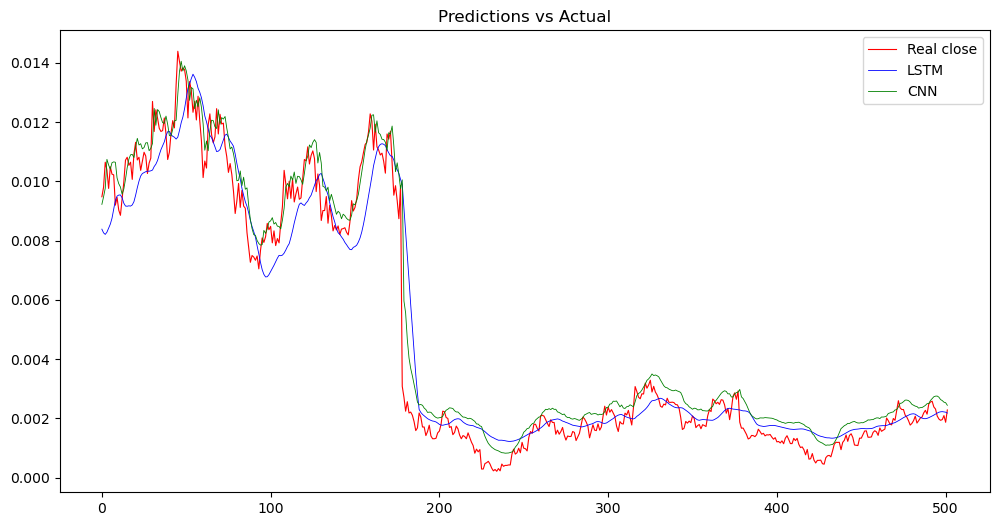

In [11]:
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import os
from keras.models import load_model, model_from_json

# 모델로드
def load_keras_model(optimizer, loss, dirx,json,h5):
    os.chdir(dirx)
    json_file = open(json,'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    model.compile(optimizer=optimizer, loss = loss)
    model.load_weights(h5)
    return model

lstm_dirx = '/Users/hwangseokjun/Desktop/All/2024/[딥러닝]주가예측/models'
lstm_json, lstm_h5 = 'LSTM_network.json', 'LSTM_weights.h5'
CNN_dirx = '/Users/hwangseokjun/Desktop/All/2024/[딥러닝]주가예측/model_test'
CNN_json, CNN_h5 = 'Tuned_CNN.json', 'Tuned_CNN_weights.h5'
optimizer = 'adam'
loss = 'mse'

# Model load
LSTM_model = load_keras_model(optimizer,loss, lstm_dirx, lstm_json, lstm_h5)
CNN_model = load_keras_model(optimizer,loss, CNN_dirx, CNN_json, CNN_h5)

# 두 모델의 예측 결과 계산
lstm_predictions = LSTM_model.predict(X_train)
cnn_predictions = CNN_model.predict(X_train)
lstm_predictions_test = LSTM_model.predict(X_test)
cnn_predictions_test = CNN_model.predict(X_test)

print("[ 손실함수 ]")
LSTM_mse = mean_squared_error(y_test, lstm_predictions_test)
print("LSTM MSE:", LSTM_mse)
CNN_mse = mean_squared_error(y_test, cnn_predictions_test)
print("CNN MSE:", CNN_mse)

plt.figure(figsize=(12, 6))
plt.plot(y_test,'r',linewidth=0.8, label = 'Real close') 
plt.plot(lstm_predictions_test,'b',linewidth=0.6, label = 'LSTM') 
plt.plot(cnn_predictions_test,'g',linewidth=0.6, label = 'CNN')     
plt.title(f"Predictions vs Actual")
plt.legend()
plt.show()

# 4일 뒤 예측 데이터셋 정규화/전처리
- X의 한세트가 4일뒤의 종가와 맵핑
- train,test를 8:2비율로 시계열이므로 test는 앞에서 뽑고 나머지는 train이다.

In [17]:
import yfinance
import numpy as np
import tensorflow as tf
import os

# Original datasetb
df = yfinance.download('AAPL','2000-1-1','2020-1-1')
df = df.drop(['Volume'],1).drop(['Adj Close'],1)
display(df)

# 정규화 0~1
def normalize_data(dataset):
    cols = dataset.columns.tolist()
    # 편의상 모든컬럼명을 인덱스(실수)로 바꿈
    col_name = [0]*len(cols)          # [0, 0, 0, 0]
    for i in range(len(cols)):
        col_name[i] = i               # [0, 1, 2, 3]
    dataset.columns = col_name
    dtypes = dataset.dtypes.tolist()
    minmax = list()
    for column in dataset:
        dataset = dataset.astype({column: 'float32'})
    # 각 컬럼의 min, max 저장(정규화를 위함)
    for i in range(len(cols)):
        col_values = dataset[col_name[i]]
        value_min = min(col_values)
        value_max = max(col_values)
        minmax.append([value_min, value_max])
    # 0~1사이값으로 정규화
    for column in dataset:
        values = dataset[column].values
        for i in range(len(values)):
            values[i] = (values[i] - minmax[column][0]) / (minmax[column][1] - minmax[column][0])
        dataset[column] = values
    dataset[column] = values
    return dataset,minmax
    

dataset, minmax = normalize_data(df)
values = dataset.values
display("< original df >", df.head(21), "< nomalized dataset >", dataset.head(21))
# 종가 예측은 11번째부터 시작 (1.18일부터)

def split_sequences(sequence, n_steps):
    X,y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1: 
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix] # 오프셋 정렬_1 : 다음날 종가를 바라본다.
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
    

def data_setup(n_steps, sequence):
    X, y = split_sequences(sequence, n_steps)
    # print("< X > \n",X[:2],X.shape)                   # X : 10일분의 데이터묶음이 5021개
    # print("< y > \n",y[:2],y.shape)                   # y : X의 각 묶음의 마지막날의 다음날데이터(예측할 타겟)
    n_features = X.shape[2]                       # X의 피쳐(특성) 수
    X = X.reshape((len(X), n_steps, n_features))  # 형태재구성 (샘플 수, 시퀀스 길이, 특성 수)
    new_y = []
    for term in y:
        new_term = term[-1]                       # 종가 컬럼만 추출
        new_y.append(new_term)
    return X, np.array(new_y), n_features

n_steps = 10        # 10일 분량
rel_test_len = 0.1  # 트 : 테 = 9 : 1
X,y,n_features = data_setup(n_steps, values)

# 오프셋 정렬_2 : x는 4일뒤 종가(y)와 맵핑된다.
X = X[:-3]
y = y[3:]


X_test, y_test =  X[:int(len(X) * rel_test_len)], y[:int(len(X) * rel_test_len)]
X_train, y_train = X[int(len(X) * rel_test_len):], y[int(len(X) * rel_test_len):]

print(" < final X > \n",X[:5], X.shape)
print(" < final y > \n",y[:10], y.shape)
print("< n_features >\n",n_features)

# array([0.9280131 , 0.95145106, 1.013393  , 0.99386203, 0.948661  ,
#        1.002232  , 0.98381704, 0.982143  , 0.907366  , 0.92633903],

[*********************100%%**********************]  1 of 1 completed
/var/folders/69/0x25zsbs24x5sj1x4z6z0sth0000gn/T/ipykernel_32334/586509774.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(['Volume'],1).drop(['Adj Close'],1)
/var/folders/69/0x25zsbs24x5sj1x4z6z0sth0000gn/T/ipykernel_32334/586509774.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(['Volume'],1).drop(['Adj Close'],1)


,Open,High,Low,Close
Date,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442
2000-01-04,0.966518,0.987723,0.903460,0.915179
2000-01-05,0.926339,0.987165,0.919643,0.928571
2000-01-06,0.947545,0.955357,0.848214,0.848214
2000-01-07,0.861607,0.901786,0.852679,0.888393
...,...,...,...,...
2019-12-24,71.172501,71.222504,70.730003,71.067497
2019-12-26,71.205002,72.495003,71.175003,72.477501
2019-12-27,72.779999,73.492500,72.029999,72.449997


'< original df >'

,0,1,2,3
Date,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442
2000-01-04,0.966518,0.987723,0.903460,0.915179
2000-01-05,0.926339,0.987165,0.919643,0.928571
2000-01-06,0.947545,0.955357,0.848214,0.848214
2000-01-07,0.861607,0.901786,0.852679,0.888393
2000-01-10,0.910714,0.912946,0.845982,0.872768
2000-01-11,0.856585,0.887277,0.808036,0.828125
2000-01-12,0.848214,0.852679,0.772321,0.778460
2000-01-13,0.843610,0.881696,0.825893,0.863839


'< nomalized dataset >'

,0,1,2,3
Date,,,,
2000-01-03,0.009710,0.010496,0.009435,0.010456
2000-01-04,0.010125,0.010268,0.009373,0.009305
2000-01-05,0.009571,0.010260,0.009598,0.009488
2000-01-06,0.009864,0.009826,0.008608,0.008389
2000-01-07,0.008679,0.009095,0.008670,0.008939
2000-01-10,0.009356,0.009247,0.008577,0.008725
2000-01-11,0.008610,0.008897,0.008051,0.008115
2000-01-12,0.008494,0.008424,0.007556,0.007436
2000-01-13,0.008431,0.008820,0.008298,0.008603


 < final X > 
 [[[0.0097097  0.01049631 0.00943526 0.01045606]
  [0.01012507 0.01026779 0.00937339 0.00930459]
  [0.00957124 0.01026017 0.00959768 0.00948759]
  [0.00986355 0.00982597 0.00860771 0.00838949]
  [0.00867898 0.0090947  0.0086696  0.00893855]
  [0.00935587 0.00924704 0.00857678 0.00872503]
  [0.00860976 0.00889664 0.00805087 0.00811497]
  [0.00849437 0.00842436 0.00755588 0.00743628]
  [0.00843091 0.00882046 0.00829836 0.00860301]
  [0.00910973 0.00924704 0.0091491  0.00905293]]

 [[0.01012507 0.01026779 0.00937339 0.00930459]
  [0.00957124 0.01026017 0.00959768 0.00948759]
  [0.00986355 0.00982597 0.00860771 0.00838949]
  [0.00867898 0.0090947  0.0086696  0.00893855]
  [0.00935587 0.00924704 0.00857678 0.00872503]
  [0.00860976 0.00889664 0.00805087 0.00811497]
  [0.00849437 0.00842436 0.00755588 0.00743628]
  [0.00843091 0.00882046 0.00829836 0.00860301]
  [0.00910973 0.00924704 0.0091491  0.00905293]
  [0.00923281 0.0097041  0.00928058 0.00947997]]

 [[0.00957124 0.01026

# CNN 하이퍼파라미터튜닝
- 저번에 한 4번파일은 카테고리컬로했으나 이번엔 뉴메리컬로 진행
- optuna + k-fold

In [19]:
import optuna
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.layers import Dropout

# 저장할 경로 설정
model_dir = "/Users/hwangseokjun/Desktop/All/2024/[딥러닝]주가예측/model_test" 
os.makedirs(model_dir, exist_ok=True)  # 경로가 없으면 생성

def create_model(trial):
    # 수치적 하이퍼파라미터 설정
    num_filters = trial.suggest_int('num_filters', 32, 128)
    kernel_size = trial.suggest_int('kernel_size', 3, 5)
    pool_size = trial.suggest_int('pool_size', 1, 2)
    dense_units = trial.suggest_int('dense_units', 50, 150)

    # 모델 생성
    model = Sequential()
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', input_shape=(10, 4)))
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mse', optimizer='adam')
    return model

def objective(trial):
    # 모델 생성
    model = create_model(trial)

    # 조기 중단(Early Stopping) 설정
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=0)
    
    # 모델 훈련
    model.fit(X_train, y_train, 
              epochs=30, 
              validation_data=(X_test, y_test), 
              callbacks=[early_stopping], 
              verbose=0)
    
    # 모델 평가
    loss = model.evaluate(X_test, y_test, verbose=0)
    return loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)


# 최적의 trial 결과 출력
best_trial = study.best_trial
print(f"최적의 trial 번호: {best_trial.number}")
print(f"최적의 값 (loss): {best_trial.value}")
print(f"best_trial : {best_trial}")

[I 2024-01-24 13:33:03,167] A new study created in memory with name: no-name-77f5f4f6-11c1-4669-8b3d-dd0ec456359b
2024-01-24 13:33:03.391639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-01-24 13:33:04.495039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
[I 2024-01-24 13:33:20,705] Trial 0 finished with value: 4.544631337921601e-06 and parameters: {'num_filters': 63, 'kernel_size': 4, 'pool_size': 2, 'dense_units': 56}. Best is trial 0 with value: 4.544631337921601e-06.
2024-01-24 13:33:20.892138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-01-24 13:33:21.997963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
[I 2024-01-24 13:33:38,037] Trial 1 finished w

최적의 trial 번호: 6
최적의 값 (loss): 1.5815361393833882e-06
best_trial : FrozenTrial(number=6, state=TrialState.COMPLETE, values=[1.5815361393833882e-06], datetime_start=datetime.datetime(2024, 1, 24, 13, 34, 48, 741234), datetime_complete=datetime.datetime(2024, 1, 24, 13, 35, 5, 956601), params={'num_filters': 80, 'kernel_size': 4, 'pool_size': 1, 'dense_units': 78}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_filters': IntDistribution(high=128, log=False, low=32, step=1), 'kernel_size': IntDistribution(high=5, log=False, low=3, step=1), 'pool_size': IntDistribution(high=2, log=False, low=1, step=1), 'dense_units': IntDistribution(high=150, log=False, low=50, step=1)}, trial_id=6, value=None)


In [21]:
# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

최적의 하이퍼파라미터:
  num_filters: 80
  kernel_size: 4
  pool_size: 1
  dense_units: 78


In [23]:
# 최적의 하이퍼파라미터로 모델 재생성 및 훈련
# best_trial = 'num_filters': 98, 'kernel_size': 5, 'pool_size': 2, 'dense_units': 112}
best_trial = study.best_trial
model = create_model(best_trial)
model.fit(X_train, y_train, 
          epochs=1000, 
          validation_data=(X_test, y_test), 
          verbose=0)

# 저장할 경로 설정
model_dir = "/Users/hwangseokjun/Desktop/All/2024/[딥러닝]주가예측/model_test" 
os.makedirs(model_dir, exist_ok=True)  # 경로가 없으면 생성

# 최적의 모델 구조를 JSON 형태로 저장
model_json = model.to_json()
with open(os.path.join(model_dir, "4days_Tuned_CNN.json"), "w") as json_file:
    json_file.write(model_json)

# 최적의 모델 가중치 저장
model.save_weights(os.path.join(model_dir, "4days_Tuned_CNN_weights.h5"))


2024-01-24 13:44:06.516290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-01-24 13:44:07.310748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


# 모델로드

In [24]:
import os
from keras.models import load_model, model_from_json

# 모델로드
def load_keras_model(optimizer, loss, dirx,json,h5):
    os.chdir(dirx)
    json_file = open(json,'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    model.compile(optimizer=optimizer, loss = loss)
    model.load_weights(h5)
    return model

CNN_dirx = '/Users/hwangseokjun/Desktop/All/2024/[딥러닝]주가예측/model_test'
CNN_json, CNN_h5 = '4days_Tuned_CNN.json', '4days_Tuned_CNN_weights.h5'
optimizer = 'adam'
loss = 'mse'

# Model load
CNN_model = load_keras_model(optimizer,loss, CNN_dirx, CNN_json, CNN_h5)

# 예측결과

105/142 [=====================>........] - ETA: 0s

2024-01-24 13:57:01.757145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 3ms/step
[ 손실함수 ]
CNN MSE: 1.0829876e-06


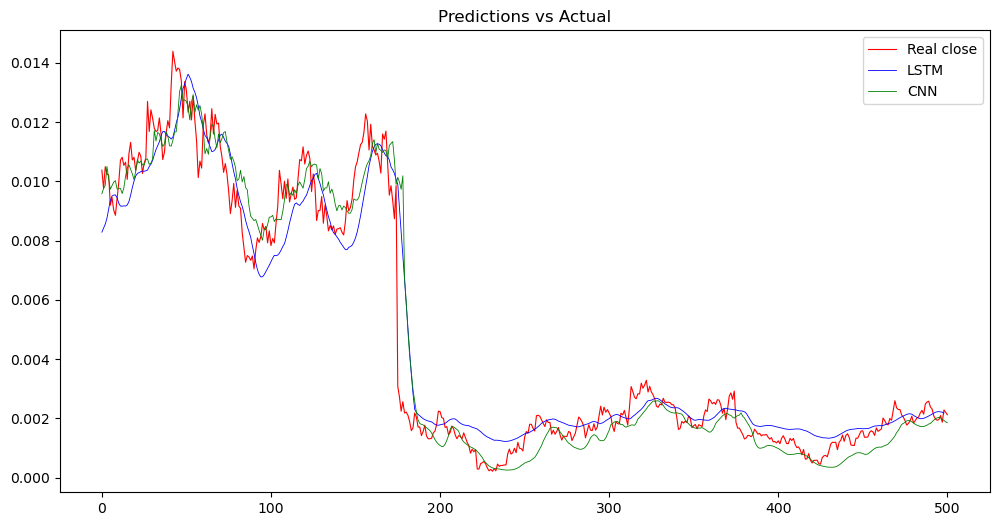

In [25]:
# 두 모델의 예측 결과 계산
cnn_predictions = CNN_model.predict(X_train)
cnn_predictions_test = CNN_model.predict(X_test)

print("[ 손실함수 ]")
CNN_mse = mean_squared_error(y_test, cnn_predictions_test)
print("CNN MSE:", CNN_mse)

plt.figure(figsize=(12, 6))
plt.plot(y_test,'r',linewidth=0.8, label = 'Real close') 
plt.plot(lstm_predictions_test,'b',linewidth=0.6, label = 'LSTM') 
plt.plot(cnn_predictions_test,'g',linewidth=0.6, label = 'CNN')     
plt.title(f"Predictions vs Actual")
plt.legend()
plt.show()